### Markov switching dynamic regression models

#### reference: 
 - example: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html
 - doc: https://www.statsmodels.org/dev/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html

#### Steps
1. download market data using yfinance: download S&P 500 ('^GSPC')
1. calculate return 20 day max return (i.e. target in supervised learning problem):
   - for each date (T):
    - calculate the max price change in next 20 trading dates: price_change = (max{close price in T+1 to T+20} - {close price on T})/({close price on T})
1. create exogenous variables: lagged dependent variable
    - lag 1 of target variable
    - lag 20 of target varable

#### Markov switching parameters
- endog: The endogenous variable. the dependent variable (i.e. the target - 20 day max return)
- k_regimes:  The number of regimes.
- trend: Whether or not to include a trend.  Default is an intercept.
  - include an intercept: trend='c'
  - include time trend: trend='t'
  - include an intercept and time trend: trend='ct' 
  - no trend: trend='n'
- exog:exogenous regressors
- switching_trend: whether or not all trend coefficients are switching across regimes.  Default is True.
- switching_exog:whether or not all regression coefficients are switching across regimes. Default is True.
- switching_variance: Whether or not there is regime-specific heteroskedasticity, i.e. whether or not the error term has a switching variance. Default is False.

#### Summary

1. switching intercept: 2 regimes v. 5 regimes
 - set k_regimes as 2 or 5 and leave the rest as default
1. switching intercept and lagged dependent variable: 
 - k_regimes = 3
 - lag 1 and lag20 as exog variables


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import datetime, timedelta
import yfinance as yf #to download stock price data

### download S&P 500 price data

In [2]:
ticker = '^GSPC'
cur_data = yf.Ticker(ticker)
hist = cur_data.history(period="max")
print(ticker, hist.shape, hist.index.min(), hist.index.max())

^GSPC (19720, 7) 1927-12-30 00:00:00 2021-11-05 00:00:00


In [3]:
df=hist[hist.index>='2000-01-01'].copy(deep=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0,0
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0,0


### calcualte max return in next 20 trading days

In [4]:
#for each stock_id, get the max close in next 20 trading days
price_col = 'Close'
roll_len=20
new_col = 'next_20day_max'
target_list = []

df.sort_index(ascending=True, inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0


In [5]:
df_next20dmax=df[[price_col]].shift(1).rolling(roll_len).max()
df_next20dmax.columns=[new_col]
df = df.merge(df_next20dmax, right_index=True, left_index=True, how='inner')

df.dropna(how='any', inplace=True)
df['target']= 100*(df[new_col]-df[price_col])/df[price_col]  

In [6]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max,target
Date,,,,,,,,,
2000-02-01,1394.459961,1412.489990,1384.790039,1409.280029,981000000,0,0,1465.150024,3.964435
2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1038600000,0,0,1465.150024,3.976243
2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1146500000,0,0,1465.150024,2.819712


In [7]:
df['lag1']=df['target'].shift(1)
df['lag20']=df['target'].shift(20)
df.dropna(how='any', inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max,target,lag1,lag20
Date,,,,,,,,,,,
2000-03-01,1366.420044,1383.459961,1366.420044,1379.189941,1274100000,0,0,1441.719971,4.533823,5.510745,3.964435
2000-03-02,1379.189941,1386.560059,1370.349976,1381.760010,1198600000,0,0,1441.719971,4.339390,4.533823,3.976243
2000-03-03,1381.760010,1410.880005,1381.760010,1409.170044,1150300000,0,0,1441.719971,2.309865,4.339390,2.819712


<AxesSubplot:xlabel='Date'>

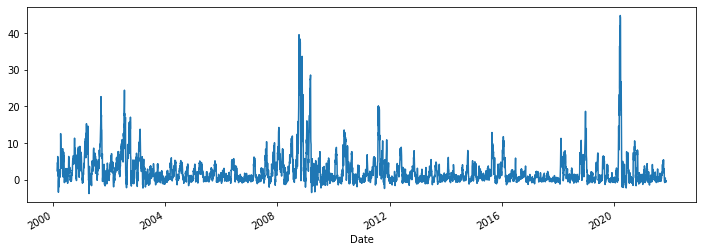

In [8]:
df['target'].plot.line(figsize=(12, 4))

### Markov switching with switching intercept: 2 regimes

- set k_regimes=2: assuming 2 regimes
- leave the rest as default


In [9]:
# Fit the model
# (a switching mean is the default of the MarkovRegession model)
markov_reg = sm.tsa.MarkovRegression(df['target'], k_regimes=2)
res_target = markov_reg.fit()
res_target.summary()

c:\users\libin.chen\documents\lc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 target   No. Observations:                 5458
Model:               MarkovRegression   Log Likelihood              -13468.861
Date:                Sat, 06 Nov 2021   AIC                          26947.723
Time:                        21:37:15   BIC                          26980.747
Sample:                             0   HQIC                         26959.246
                               - 5458                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6017      0.042     38.541      0.000       1.520       1.683
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3001      0.237     56.154      0.000      12.836      13.764
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.5238      0.147     51.137      0.000       7.235       7.812
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9946      0.001    923.936      0.000       0.992       0.997
p[1->0]        0.0701      0.014      5.182      0.000       0.044       0.097
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

- note when P>|z| is not small (typically less than 0.05), we accept null hypothesis.
- From the summary output, the first regime (the “low regime”) is estimated to be 1.6 whereas in the “high regime” it is 13.3. Below we plot the smoothed probabilities of being in the high regime. 

<AxesSubplot:title={'center':'Probability of being in the high regime'}, xlabel='Date'>

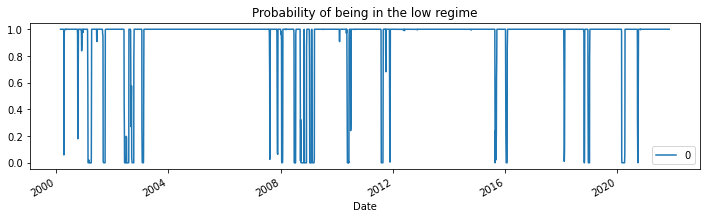

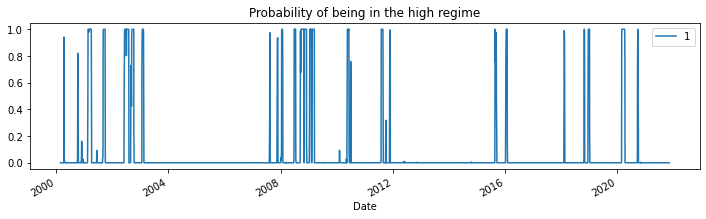

In [10]:
res_target.smoothed_marginal_probabilities[[0]].plot(
    title="Probability of being in the low regime", figsize=(12, 3)
)
res_target.smoothed_marginal_probabilities[[1]].plot(
    title="Probability of being in the high regime", figsize=(12, 3)
)

- From the estimated transition matrix we can calculate the expected duration of a low regime versus a high regime.

In [11]:
print(res_target.expected_durations)

[185.00635239  14.26299654]


### Markov switching with switching intercept: 5 regimes

- set k_regimes=5: assuming 5 regimes
- leave the rest as default


In [12]:
# Fit the model
# (a switching mean is the default of the MarkovRegession model)
markov_reg = sm.tsa.MarkovRegression(df['target'], k_regimes=5)
res_target = markov_reg.fit()
res_target.summary()

c:\users\libin.chen\documents\lc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\libin.chen\documents\lc_env\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\libin.chen\documents\lc_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 target   No. Observations:                 5458
Model:               MarkovRegression   Log Likelihood              -10388.194
Date:                Sat, 06 Nov 2021   AIC                          20828.388
Time:                        21:39:57   BIC                          21000.114
Sample:                             0   HQIC                         20888.309
                               - 5458                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5066      0.027     18.914      0.000       0.454       0.559
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5746      0.072     49.828      0.000       3.434       3.715
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7889      0.112     69.659      0.000       7.570       8.008
                             Regime 3 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8677      0.140    106.019      0.000      14.593      15.143
                             Regime 4 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.9587      0.212    145.718      0.000      30.542      31.375
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.7108      0.036     47.337      0.000       1.640       1.782
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9708        nan        nan        nan         nan         nan
p[1->0]        0.0780      0.001     55.775      0.000       0.075       0.081
p[2->0]        0.0213        nan        nan        nan         nan         nan
p[3->0]        0.0128      0.012      1.109      0.268      -0.010       0.035
p[4->0]     8.241e-06      0.000      0.019      0.985      -0.001       0.001
p[0->1]        0.0278      0.001     24.099      0.000       0.026       0.030
p[1->1]        0.8680      0.001   1313.738      0.000       0.867       0.869
p[

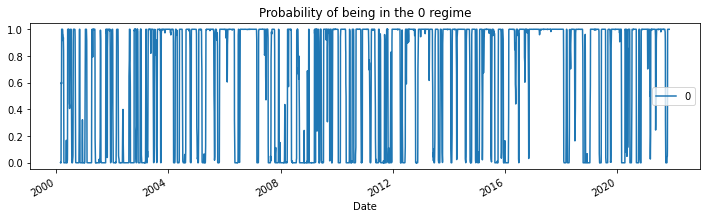

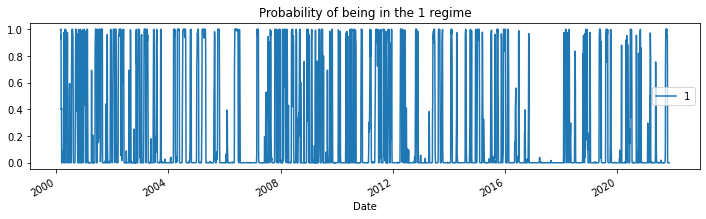

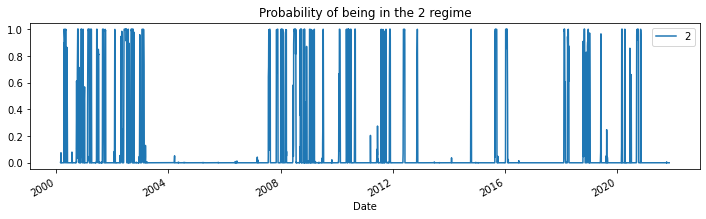

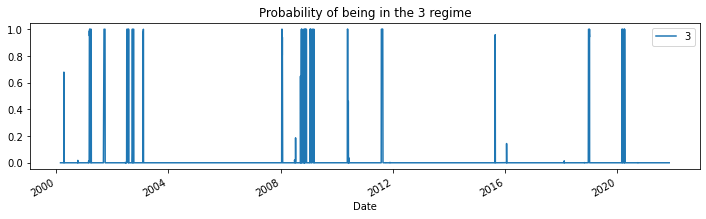

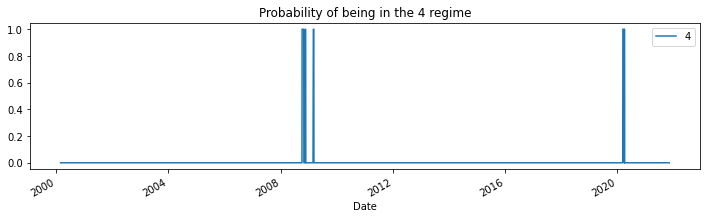

In [13]:
for i in range(5):
    res_target.smoothed_marginal_probabilities[[i]].plot(
        title=f"Probability of being in the {i} regime", figsize=(12, 3)
    )


In [14]:
print(res_target.expected_durations)

[3.42706644e+01 7.57564599e+00 5.01865546e+00 5.26380977e+00
 7.13942479e+04]


### Markov switching with switching intercept and exogenous variables

- set k_regimes=3: assuming 3 regimes
- lag 1 and lag20 as exogenous variables
- Because the models can be often difficult to estimate, for the 3-regime model we employ a search over starting parameters to improve results, specifying 50 random search repetitions.

In [15]:
# Fit the model
# (a switching mean is the default of the MarkovRegession model)
markov_reg = sm.tsa.MarkovRegression(df['target'], k_regimes=3, exog=df[['lag1', 'lag20']])
res_target = markov_reg.fit()
res_target.summary()

c:\users\libin.chen\documents\lc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 target   No. Observations:                 5458
Model:               MarkovRegression   Log Likelihood               -8402.891
Date:                Sat, 06 Nov 2021   AIC                          16837.782
Time:                        21:40:27   BIC                          16943.459
Sample:                             0   HQIC                         16874.656
                               - 5458                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2457      0.030      8.124      0.000       0.186       0.305
x1             0.7263      0.006    121.947      0.000       0.715       0.738
x2            -0.0624      0.006    -10.622      0.000      -0.074      -0.051
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0278      0.034      0.821      0.412      -0.039       0.094
x1             0.9996      0.006    171.072      0.000       0.988       1.011
x2             0.0788      0.008      9.287      0.000       0.062       0.095
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3858      0.118      3.274      0.001       0.155       0.617
x1             1.3538      0.014     98.518      0.000       1.327       1.381
x2             0.0428      0.016      2.653      0.008       0.011       0.074
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.8872      0.021     42.126      0.000       0.846       0.928
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5232      0.039     13.336      0.000       0.446       0.600
p[1->0]        0.4120      0.029     14.022      0.000       0.354       0.470
p[2->0]        0.3652      0.055      6.611      0.000       0.257       0.473
p[0->1]        0.4031      0.041      9.779      0.000       0.322       0.484
p[1->1]        0.4723      0.034     14.089      0.000       0.407       0.538
p[2->1]        0.5848      0.057     10.222      0.000       0.473       0.697
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

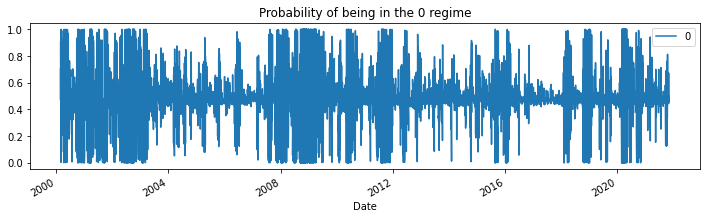

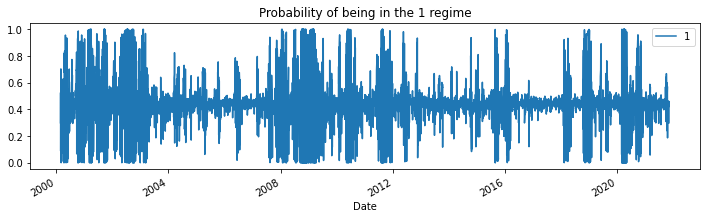

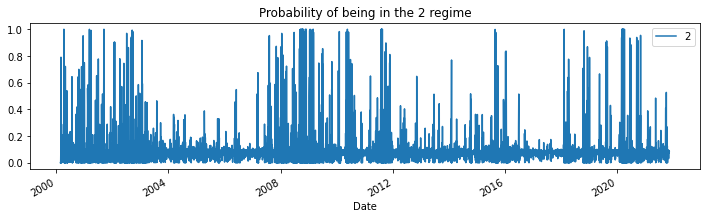

In [16]:
for i in range(3):
    res_target.smoothed_marginal_probabilities[[i]].plot(
        title=f"Probability of being in the {i} regime", figsize=(12, 3)
    )

In [17]:
np.random.seed(5678)

markov_reg = sm.tsa.MarkovRegression(df['target'], k_regimes=3, 
                                     trend="c", #{‘n’, ‘c’, ‘t’, ‘ct’}
                                     #switching_trend=False, 
                                     #switching_exog=False,
                                     switching_variance=True, 
                                     exog=df[['lag20']]
                                    )
res_target = markov_reg.fit(search_reps=50, method='bfgs')
res_target.summary()

c:\users\libin.chen\documents\lc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 target   No. Observations:                 5458
Model:               MarkovRegression   Log Likelihood               -9471.406
Date:                Sat, 06 Nov 2021   AIC                          18972.812
Time:                        21:40:58   BIC                          19071.885
Sample:                             0   HQIC                         19007.382
                               - 5458                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2896      0.018     16.545      0.000       0.255       0.324
x1            -0.0239      0.005     -4.748      0.000      -0.034      -0.014
sigma2         0.4468      0.018     25.439      0.000       0.412       0.481
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9133      0.061     47.784      0.000       2.794       3.033
x1            -0.0071      0.011     -0.663      0.507      -0.028       0.014
sigma2         1.7139      0.106     16.204      0.000       1.507       1.921
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5583      0.306     27.989      0.000       7.959       9.158
x1             0.3187      0.043      7.347      0.000       0.234       0.404
sigma2        36.3329      1.987     18.285      0.000      32.438      40.227
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9523        nan        nan        nan         nan         nan
p[1->0]        0.0785      0.007     11.245      0.000       0.065       0.092
p[2->0]        0.0029      0.003      1.114      0.265      -0.002       0.008
p[0->1]        0.0477      0.002     30.042      0.000       0.045       0.051
p[1->1]        0.8910      0.008    106.474      0.000       0.875       0.907
p[2->1]        0.0673      0.010      6.811      0.000       0.048       0.087
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

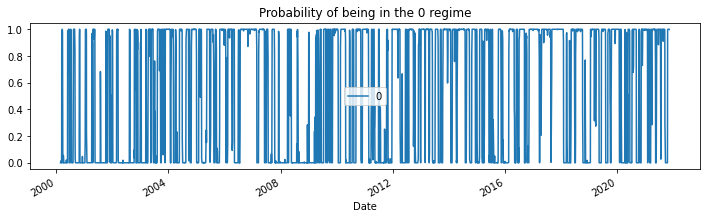

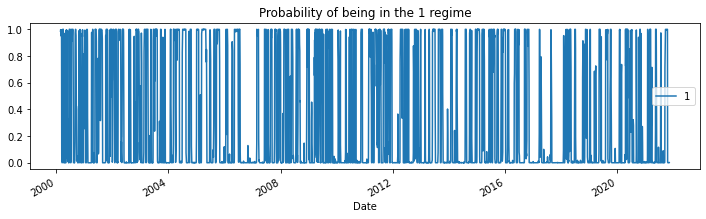

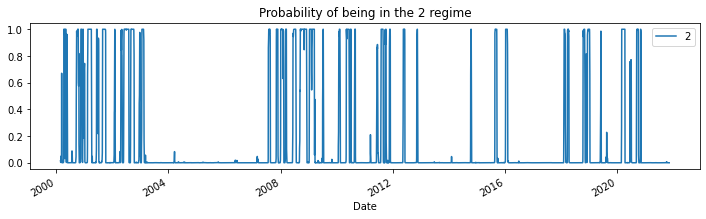

In [18]:
for i in range(3):
    res_target.smoothed_marginal_probabilities[[i]].plot(
        title=f"Probability of being in the {i} regime", figsize=(12, 3)
    )

In [19]:
np.random.seed(5678)

markov_reg = sm.tsa.MarkovRegression(df['target'].iloc[:-100], k_regimes=3, 
                                     trend="c", #{‘n’, ‘c’, ‘t’, ‘ct’}
                                     #switching_trend=False, 
                                     #switching_exog=False,
                                     switching_variance=True, 
                                     exog=df[['lag20']].iloc[:-100]
                                    )
res_target = markov_reg.fit(search_reps=50, method='bfgs')
res_target.summary()

c:\users\libin.chen\documents\lc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\libin.chen\documents\lc_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 target   No. Observations:                 5358
Model:               MarkovRegression   Log Likelihood               -9347.917
Date:                Sat, 06 Nov 2021   AIC                          18725.834
Time:                        21:41:29   BIC                          18824.629
Sample:                             0   HQIC                         18760.339
                               - 5358                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2965      0.018     16.736      0.000       0.262       0.331
x1            -0.0233      0.005     -4.849      0.000      -0.033      -0.014
sigma2         0.4539      0.016     28.239      0.000       0.422       0.485
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9293      0.064     46.106      0.000       2.805       3.054
x1            -0.0064      0.011     -0.601      0.548      -0.027       0.015
sigma2         1.7220      0.111     15.491      0.000       1.504       1.940
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5903      0.308     27.899      0.000       7.987       9.194
x1             0.3182      0.043      7.435      0.000       0.234       0.402
sigma2        36.4287      1.965     18.542      0.000      32.578      40.279
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9522   3.01e-05   3.16e+04      0.000       0.952       0.952
p[1->0]        0.0784      0.007     11.100      0.000       0.065       0.092
p[2->0]        0.0029      0.003      1.146      0.252      -0.002       0.008
p[0->1]        0.0478   9.76e-06   4895.569      0.000       0.048       0.048
p[1->1]        0.8905      0.009    104.534      0.000       0.874       0.907
p[2->1]        0.0675      0.010      6.828      0.000       0.048       0.087
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""